# Culinary Clustering - Data Analysis

Hello and welcome to the data analysis notebook of my Coursera Capstone project: **Culinary Clustering**. An introduction to the topic of the notebook, a review of the used databases and a detailed description of the get_venues-function which I will define in the next block can be found in the Introduction&Data.ibynb file (link).

## Preparation and Data Acquisition

First we import all needed libraries and define a function to get the venue location data from foursquare.

In [1]:
!pip install geographiclib
import pandas as pd
import numpy as np
import folium
import matplotlib.colors as colors
import requests as req
import seaborn as sns
import matplotlib.pyplot as plt
import json as js
from matplotlib import cm
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
import zipfile
import getpass
import folium.plugins as fplugins
import os
import ast
import collections

def get_venues(lat_center,long_center,name,ID,SECRET,rad=10000,max_lvl=5):
    angles=[0,60,120,180,240,300]
    lvl=0
    VERSION = '20180605' # Foursquare API version
    df_venues=pd.DataFrame()
    df_items=pd.DataFrame()
    df_requests=pd.DataFrame(columns=['lati','lngi','lvl','items','dist'])
    df_requests=df_requests.append({'lati':lat_center, 'lngi':long_center, 'lvl': lvl, 'items':100, 'dist':0}, ignore_index=True)
    requests=1
    while lvl < max_lvl:
        df=df_requests[(df_requests['lvl']==lvl) & (df_requests['items']>99)].reset_index()
        for i in range(len(df)):
            df_requests=df_requests.append({'lati':df.loc[i,'lati'], 'lngi':df.loc[i,'lngi'], 'lvl': lvl+1,'dist':0}, ignore_index=True)
            for angle in angles:
                geo=geod.Direct(df.loc[i,'lati'],df.loc[i,'lngi'],angle,rad/2**(lvl)*0.866)
                dist=geod.Inverse(lat_center,long_center,geo['lat2'],geo['lon2'])['s12']
                #check if circle is within the initial search radius
                if dist< rad+rad/2**(lvl+1):
                    df_requests=df_requests.append({'lati':geo['lat2'], 'lngi':geo['lon2'], 'lvl': lvl+1, 'dist':dist}, ignore_index=True)
        lvl=lvl+1
        #drop duplicate circles
        #df_requests.drop_duplicates(subset=['lati','lngi','lvl'],inplace=True)
        #the drop duplicate method does not work since the position of similar circles is not exactly equal.
        #Therefore we measure the distance between every point and drop one of the points if the distance is below 100m
        droplist=[True]*len(df_requests)
        for i in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
            df_requests=df_requests.reset_index(drop=True)
            for j in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
                if (i!= j):
                    dist=geod.Inverse(df_requests.loc[i,'lati'],df_requests.loc[i,'lngi'],df_requests.loc[j,'lati'],df_requests.loc[j,'lngi'])['s12']
                    if (dist < 100) & droplist[i]==True:
                        droplist[j]=False
        df_requests=df_requests[droplist]
        df_requests=df_requests.reset_index(drop=True)
        for i in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(ID, SECRET, df_requests.loc[i,'lati'], df_requests.loc[i,'lngi'], VERSION, rad/2**df_requests.loc[i,'lvl'],100)
            results = req.get(url).json()
            requests=requests +1
            #print(requests,url,results['response'])
            if results['response'] == {}:
                print('empty response')
            else:
                nvenues=len(results['response']['groups'][0]['items'])
                df_requests.loc[i,'items']=nvenues
                items = results['response']['groups'][0]['items']
                df_items= pd.json_normalize(items)
                if len(df_items)>0:
                    #if all returned locations are in neighboring cities we invert the nvenues. This way they are always below 100 and the place will not be searched again
                    df_items['venue.location.formattedAddress']=df_items['venue.location.formattedAddress'].apply(', '.join)
                    if len(df_items[df_items['venue.location.formattedAddress'].str.contains(name)])<1:
                        df_requests.loc[i,'items']=-nvenues
                    df_venues=df_venues.append(df_items)
    #df_venues=df_venues[df_venues['venue.location.formattedAddress'].str.contains(name)]]
    print(name + ': made ' +  str(requests)+ ' requests, obtained ' + str(len(df_venues)) + ' venues.')
    print(str(len(df_requests[(df_requests['items']==100)&(df_requests['lvl']==max_lvl)])) + ' highest level requests with 100 items (or more)')
    return df_venues.reset_index(drop=True), df_requests

I use the getpass library to keep my login-data secret. Let's set up the foursquare credentials:

In [3]:
#foursquare set-up
CLIENT_ID = getpass.getpass('ID:')
CLIENT_SECRET = getpass.getpass('SECRET:')


ID:········
SECRET:········


We load the simplemaps file, which contains the location data of the cities of the world. More information can be found on the simplemaps website https://simplemaps.com/data/world-cities in the Introdction&Data.ibynb notebook.

In [2]:
#url_zip = urllib.request.urlopen("http://www.unece.org/fileadmin/DAM/cefact/locode/loc162txt.zip")
!wget -O simplemaps.zip https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.6.zip
 
zf = zipfile.ZipFile('simplemaps.zip')
df_city = pd.read_csv(zf.open('worldcities.csv'))
#remove all cities with fewer than 100000 population
df_city=df_city[df_city['population']>500000]
#make city-name index
df_city = df_city.set_index('city_ascii')

#df_city.loc['Bremen']

--2020-09-01 14:21:47--  https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.6.zip
Resolving simplemaps.com (simplemaps.com)... 104.26.13.95, 104.26.12.95, 172.67.71.113, ...
Connecting to simplemaps.com (simplemaps.com)|104.26.13.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1505132 (1,4M) [application/zip]
Saving to: ‘simplemaps.zip’

simplemaps.zip      100%[===================>]   1,43M  1,97MB/s    in 0,7s    

2020-09-01 14:21:48 (1,97 MB/s) - ‘simplemaps.zip’ saved [1505132/1505132]



Let us define a list that contains all the cities we would like to explore, run the get_venues-function on each of the cities and store the obtained data in .csv files. This way we don't have to make this large amount of foursquare requests again. The following code checks if a .csv file exists for each city in the city list. If not, it loads the data from foursquare, otherwise it loads the data from the .csv file. The obtained data will be stored in dictionaries that links the name of the city to a pandas dataframe. The venues-dictionary contains the venue dataframes for all cities in the city list, while the requests dictionary contains the requests made by the get_venues function.

In [3]:
CityList=['Berlin','London','Paris']
venues = {}
requests = {}
for city in CityList:
    if os.path.isfile('./'+ city+'_venues.csv') and os.path.isfile('./'+ city+'_requests.csv'):
        venues[city]=pd.read_csv('./'+ city+'_venues.csv')
        requests[city]=pd.read_csv('./'+ city+'_requests.csv')
        print(city + ': read ' +  str(len(requests[city]))+ ' requests, obtained ' + str(len(venues[city])) + ' venues.')
    else:
        print('#')
        lat_center=df_city.loc[city,'lat']
        long_center=df_city.loc[city,'lng']   
        venues[city], requests[city] = get_venues(lat_center,long_center,city,CLIENT_ID,CLIENT_SECRET,max_lvl=5)
        venues[city].to_csv(city+'_venues.csv')
        requests[city].to_csv(city+'_requests.csv')

Berlin: read 347 requests, obtained 17383 venues.
London: read 495 requests, obtained 27380 venues.
Paris: read 357 requests, obtained 20083 venues.


As described in the Introduction&Data notebook, the requests made by the get_venues function can be represented by circles on a map. Here I show the requests made by my function for the city of Berlin. Smaller circles (yellow) indicate that the density of venues in this area is high. Or more specifically: yellow circles appear in every orange circle in which the number of venues returned by the explore endpoint exceeds 100 venues. Please use nbviewer (https://nbviewer.jupyter.org/) to read this notebook in order to see the maps in this github repositories.

In [4]:
n=0

map = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)

colors_array = cm.hot(np.linspace(0, 0.8, 6))
palette = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, lvl in zip(requests[CityList[n]]['lati'], requests[CityList[n]]['lngi'], requests[CityList[n]]['lvl']):
        folium.vector_layers.Circle(
            [lat, lng],
            radius=10000/2**lvl,
            color=palette[int(lvl)],
            fill=False,
            fill_opacity=0,
            parse_html=False).add_to(map)
      
map

## Data Wrangling

Let's start to wrangle with the data. I define a function that obtains the category of each venue from a dataframe. Venues with a duplicate ID, venues with addresses that do not contain the name of the city are dropped from the dataframe. The symbol **\`** is replaced by a **'** because the first symbol causes trouble in the data evaluation. Next the get_category function is applied. Finally, we drop every row that is a duplicate in the name and category field.

In [5]:
def get_category_type(row):
    categories_list = ast.literal_eval(row['venue.categories'])   
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']    

venues2={}
unique=[]
for city in CityList:
    venues2[city]=venues[city].drop_duplicates(subset=['referralId'])
    venues2[city]=venues2[city][venues2[city]['venue.location.formattedAddress'].str.contains(city)]
    venues2[city]['venue.name']=venues2[city]['venue.name'].str.replace('`',"'")
    venues2[city]['category']=venues2[city].apply(get_category_type, axis=1)
    venues2[city]=venues2[city].drop_duplicates(subset=['venue.name','category'])


We would like to have a list of all the categories of the venues obtained from foursquare. For this purpose we use the categories endpoint of foursquare. It returns a hierarchical dictionary in .json format. Again we save this file to avoid making the same requests to foursquare multiple times.  

In [6]:
if os.path.isfile("./categories.json"):
    with open("categories.json", "r") as infile:
        results = js.load(infile)
else:    
    with open("categories.json", "w") as outfile:
        VERSION = '20180605'
        url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,)
        results = req.get(url).json()
        js.dump(results, outfile)

The content of the .json file obtained from the foursquare categories endpoint is similar to the content shown on the following website https://developer.foursquare.com/docs/build-with-foursquare/categories/ . We are interested in the "Food" and "Nightlife Spot" Categories. These are category 3 and 4 in the .json file. The following routine walks through the .json file and returns a list named categories, which contains every category in the in the "Food" and "Nightlife Spot" Categories. Furthermore, it returns a list with the name subcategories, which maps every category to a top-level category, i.e. Ethiopian Restaurant is mapped to African Restaurant; Burmese, Cambodian, Chinese, Anhui, Beijing ... Tibetan and Vietnamese Restaurants are mapped to Asian Restaurant; and so one. This dictionary will help us to get a better overview over the obtained data set.


In [7]:
df_items= pd.DataFrame()
subcategories={}
for i in range(3,5):
    df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories']))
    for j in range(len(results['response']['categories'][i]['categories'])):
        df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories'][j]['categories']))
        if results['response']['categories'][i]['categories'][j]['categories'] != []:
            for k in range(len(results['response']['categories'][i]['categories'][j]['categories'])):
                subcategories.update({results['response']['categories'][i]['categories'][j]['categories'][k]['name'] : results['response']['categories'][i]['categories'][j]['name']})
                df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories'][j]['categories'][k]['categories']))
                if results['response']['categories'][i]['categories'][j]['categories'] != []:
                    for l in range(len(results['response']['categories'][i]['categories'][j]['categories'][k]['categories'])):
                        subcategories.update({results['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['name'] : results['response']['categories'][i]['categories'][j]['name']})
        else:
             subcategories.update({results['response']['categories'][i]['categories'][j]['name'] : results['response']['categories'][i]['categories'][j]['name']})
categories=df_items['name'].to_list()
#subcategories

Let's drop all venues that are not in the culinary categories and map the subcategories to the top-level categories.

In [8]:
venues3={}
for city in CityList:
    venues3[city]=venues2[city][venues2[city]['category'].isin(categories)]
    venues3[city]=venues3[city].reset_index(drop=True)

for city in CityList:
    venues3[city]['main_category']=venues3[city]['category'].map(subcategories)
    venues3[city]['main_category'].fillna(venues3[city]['category'], inplace=True)
    
venues3['Berlin'][['venue.name','venue.location.lng','venue.location.lat','category','main_category']].head(10)

venue.name  venue.location.lng  venue.location.lat  \
0             BEN RAHIM           13.401928           52.525168   
1                Kin-Za           13.395808           52.524928   
2      Father Carpenter           13.406614           52.524469   
3               19grams           13.407440           52.522697   
4             Mr. Susan           13.395542           52.524365   
5        Cuore di vetro           13.408723           52.526577   
6          Cocolo Ramen           13.399299           52.527237   
7          Klub Kitchen           13.408988           52.524849   
8  Chipperfield Kantine           13.400817           52.528204   
9        Banh Mi Stable           13.408235           52.526965   

               category         main_category  
0           Coffee Shop           Coffee Shop  
1  Caucasian Restaurant  Caucasian Restaurant  
2           Coffee Shop           Coffee Shop  
3           Coffee Shop           Coffee Shop  
4          Cocktail Bar                   Bar  
5        Ice Cream Shop          Dessert Shop  
6      Ramen Restaurant      Asian Restaurant  
7                Bistro                Bistro  
8                Bistro                Bistro  
9        Sandwich Place        Sandwich Place

## Culinary Fingerprint of the Cities

As the first step of evaluation of the data acquired from Foursquare the culinary composition of the cities is plotted as bar charts. We use the top-level categories in order to get a better overview over the dataset. Furthermore, we remove any category that appears less than 50 times in any one city.

In [9]:
cat50=[]
for city in CityList:
    df=venues3[city].groupby('main_category').count().iloc[:,0:1]
    df=df.rename(columns={'Unnamed: 0': 'n_venues'})
    cat50.extend(df[df['n_venues']>=50].index.to_list())
    
cat50=np.unique(cat50)
cat50

array(['Asian Restaurant', 'Bakery', 'Bar', 'Bistro', 'Breakfast Spot',
       'Brewery', 'Burger Joint', 'Café', 'Coffee Shop', 'Creperie',
       'Deli / Bodega', 'Dessert Shop', 'English Restaurant',
       'Falafel Restaurant', 'Fish & Chips Shop', 'French Restaurant',
       'Gastropub', 'German Restaurant', 'Greek Restaurant',
       'Indian Restaurant', 'Italian Restaurant',
       'Latin American Restaurant', 'Mediterranean Restaurant',
       'Middle Eastern Restaurant', 'Nightclub', 'Pizza Place',
       'Restaurant', 'Sandwich Place', 'Spanish Restaurant',
       'Turkish Restaurant', 'Vegetarian / Vegan Restaurant'],
      dtype='<U29')

/home/tobias/miniconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


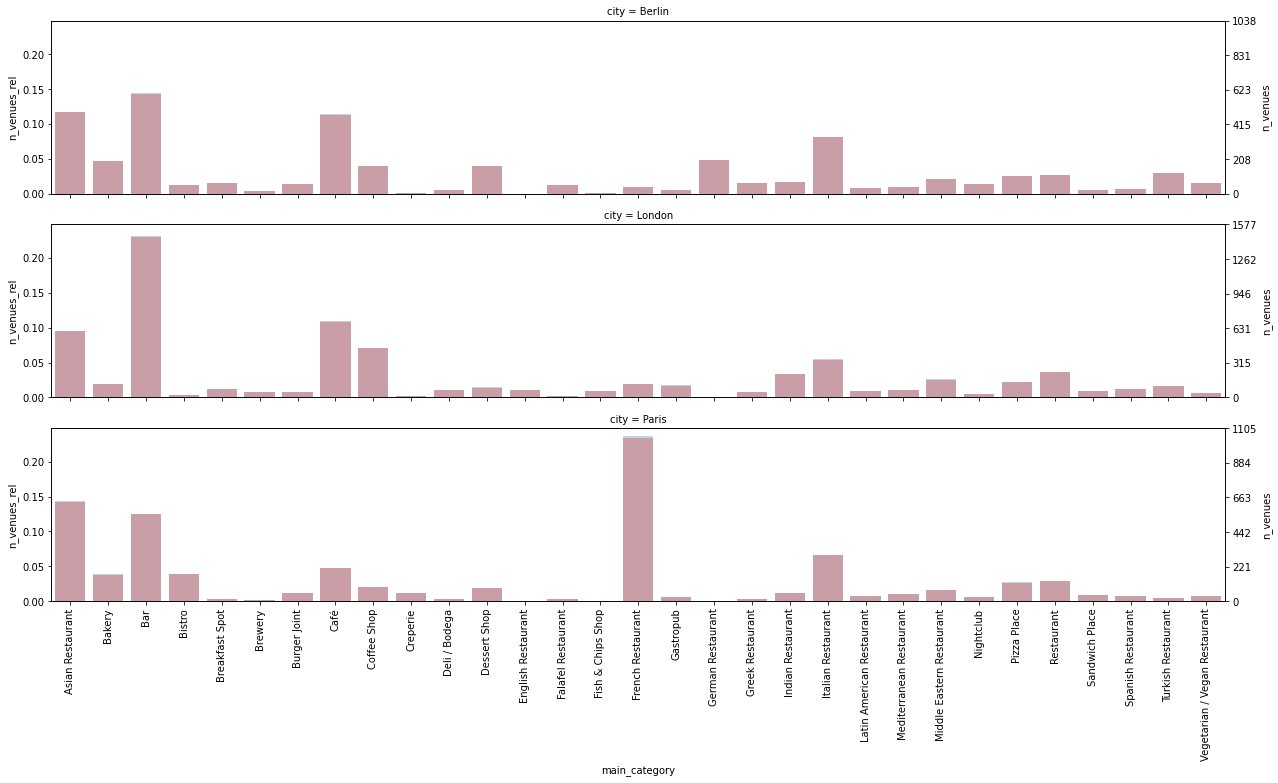

In [10]:
cat_composition=pd.DataFrame()
n_venues_tot={}

for city in CityList:
    df2=venues3[city].groupby('main_category').count().iloc[:,0:1]
    df2=df2.rename(columns={'Unnamed: 0': 'n_venues'})
    df2=df2.reset_index()
    for cat in pd.unique(list(subcategories.values())):
        if df2['main_category'].str.match(cat).sum() < 1:
            df2=df2.append({'main_category': cat, 'n_venues': 0 }, ignore_index=True)
    df2=df2.sort_values('main_category')
    df2['city']=city
    n_venues_tot[city]=df2['n_venues'].sum()
    df2['n_venues_rel']=df2['n_venues']/n_venues_tot[city]
    cat_composition=cat_composition.append(df2)

df=cat_composition[cat_composition['main_category'].isin(cat50)]

grid= sns.FacetGrid(df, row='city', height=3, aspect=6,despine=False)
#for i in df['kmeans_cluster_label'].unique():
#    df2=df[df['kmeans_cluster_label']==i]
grid.map(sns.barplot,'main_category','n_venues_rel',alpha=0.3)
grid.set_xticklabels(rotation=90)

for i,city in zip(range(len(CityList)),CityList):
    ax2=grid.axes[i][0].twinx()
    ax2 = sns.barplot(x='main_category', y='n_venues', data = df[df['city']==city],ci=None,color='red',alpha=0.3)
    ax2.set_yticks(grid.axes[i][0].get_yticks()*n_venues_tot[city])
    
sns.set(font_scale=1.3)


As we can see, the culinary composition of the cities in some categories is quite unique. For example, the relative number of French Restaurants in Paris and the number of Bars in London are significant above the relative number of similar venues in the other cities. Surprisingly, the relative number of Cafés in Paris is below the average of the other cities.

The relative number of venues in other categories, like Asian Restaurants, Italian Restaurants, Pizza Places, etc. seem to be rather similar. For each city we obtained a unique composition or "culinary fingerprint".

## Spatial Clustering

We would like to find out which venues tend to be close to each other. In order to do this we will cluster the geolocations of the venues. In order to get an overview of the venues and the clusters they will form we can use the simple MarkerCluster-plugin of the folium library. Let's focus on the city of Berlin for a start. Please use nbviewer (https://nbviewer.jupyter.org/) to read this notebook in order to see the maps in this github repositories.

In [11]:
n=0                                         
map2 = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)

venues_cluster = fplugins.MarkerCluster().add_to(map2)

for lat, lng, label, cat in zip(venues3[CityList[n]]['venue.location.lat'], venues3[CityList[n]]['venue.location.lng'], venues3[CityList[n]]['venue.name'].str.replace('`',"'"),venues3[CityList[n]]['category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=cat + ": " + label,
    ).add_to(venues_cluster)
    
map2

Let's use a more scientific method for the spatial clustering, i.e. the density-based algorithm DBSCAN. The spatial data we would like to analyze are the geocoordinates of the venues, i.e. the latitude and longitude. While a difference in latitude is always proportional to a distance (two locations with a difference in latitude of $\Delta \lambda = 0.1 °$ are always $\Delta s = r_\mathrm{E} \cdot \Delta \lambda \cdot \frac{\pi}{180} \approx 11.1 \, \mathrm{km}$ apart), the distance of two locations with different longitudes (and same latitudes) depends on their shared latitude. This can easily be understood by looking at this figure: https://en.wikipedia.org/wiki/Geographic_coordinate_system#/media/File:FedStats_Lat_long.svg The circumference of the circles in the right part of the figure depends on the latitude. Therefore the arc described by a longitude difference will depend on the latitude as well. In order to correct this and obtain two spatial parameter that are directly proportional to the distance between two venues we need to multiply the longitude of every venue with the cosine of its latitude.


DBSCAN uses two parameters. The first one "eps" describes the radius in which a specific number of points must be found in order to produce a cluster. The second "min_samples" is the minimum number of points we need to produce a cluster. Since we like to analyze the composition of the clusters we will avoid clusters that are composed of fewer than 7 venues. For a small eps-value only a small number of clusters will be found, since the density needed to produce a new cluster is quite high. For large eps-values the clusters tend to merge together, reducing again the total number of clusters. We try different values for the eps-parameter in order to find a value were we get the largest number of spatial clusters. 

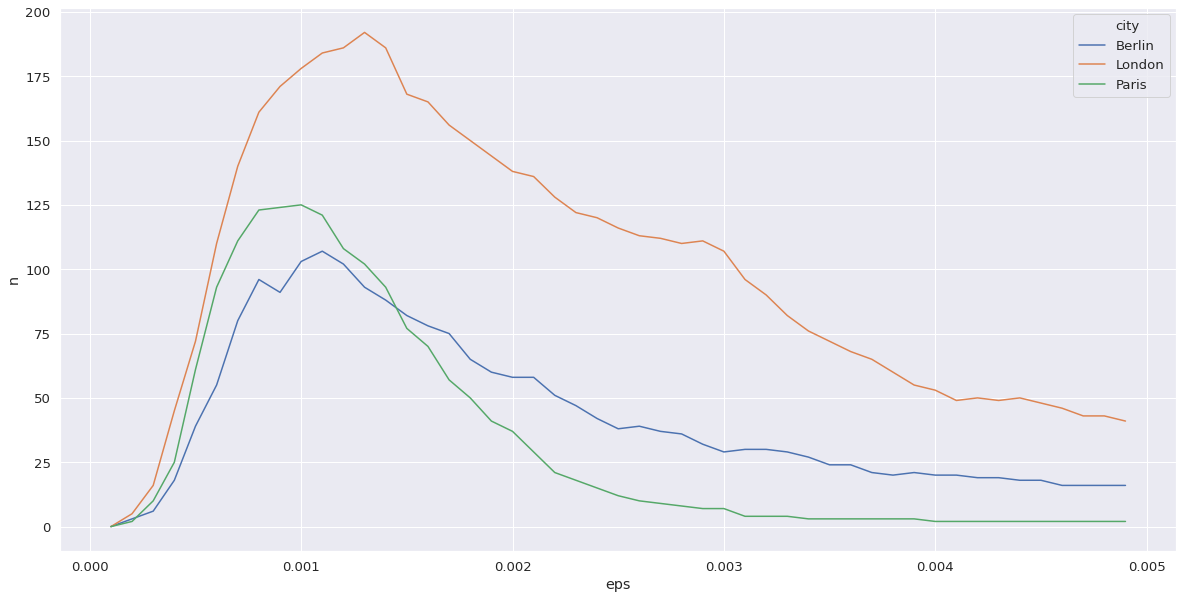

In [12]:
for city in CityList:
    venues3[city]['venue.location.lng.cor']=venues3[city]['venue.location.lng']*np.cos(np.deg2rad(venues3[city]['venue.location.lat']))


from sklearn.cluster import DBSCAN
df=pd.DataFrame()
i=0
for city in CityList:
    for eps in np.arange(0.0001,0.005,0.0001):
        ClusterData = venues3[city][['venue.location.lat','venue.location.lng.cor']]
        db = DBSCAN(eps=eps, min_samples=7).fit(ClusterData)
        unique_labels = set(db.labels_)
        df.loc[i,'eps']=eps
        df.loc[i,'n']=len(unique_labels)-1
        df.loc[i,'city']=city
        i=i+1


df        

sns.set(font_scale=1.2, rc={'figure.figsize':(20,10)})
sns.lineplot('eps','n',data=df,hue='city')

We obtain the largest number of clusters for an eps-value around $\epsilon=0.0011$. We use this value and cluster the spatial data of the venues in all cities and add the obtained cluster labels to the respective dataframes.

In [13]:
for city in CityList:
    ClusterData = venues3[city][['venue.location.lat','venue.location.lng.cor']]
    #db = DBSCAN(eps=0.0010, min_samples=10).fit(ClusterData)
    db = DBSCAN(eps=0.0011, min_samples=7).fit(ClusterData)
    labels = db.labels_
    unique_labels = set(labels)
    print(city, unique_labels)
    venues3[city]['cluster_label']=labels

Berlin {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, -1}
London {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 

The DBSCAN algorithm produces 107 clusters in Berlin. The location of these clusters are shown in the next figure. 

In [14]:
n=0
nlabels=len(venues3[CityList[n]]['cluster_label'].unique())-1
colors_array = cm.hsv(np.linspace(0, 1, nlabels))
palette = [colors.rgb2hex(i) for i in colors_array]



map3 = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)
for i in range(0,nlabels):
    df=venues3[CityList[n]][venues3[CityList[n]]['cluster_label']==i]
    for lat, lng, name in zip(df['venue.location.lat'], df['venue.location.lng'],df['venue.name']):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=str(i) + ": " + name,
            color=palette[i],
            fill=True,
            fill_color=palette[i],
            fill_opacity=1,
            parse_html=False).add_to(map3)

map3


## Analysis of unclustered Data

The data labeled with the "-1" cluster label can not be assigned to any cluster. Before we continue to evaluate the clustered data let us first evaluate the composition of this data that is not assigned to any cluster. We compare the composition of the unclustered data with the mean composition of venues categories in Berlin by subtracting the relative counts from each other.

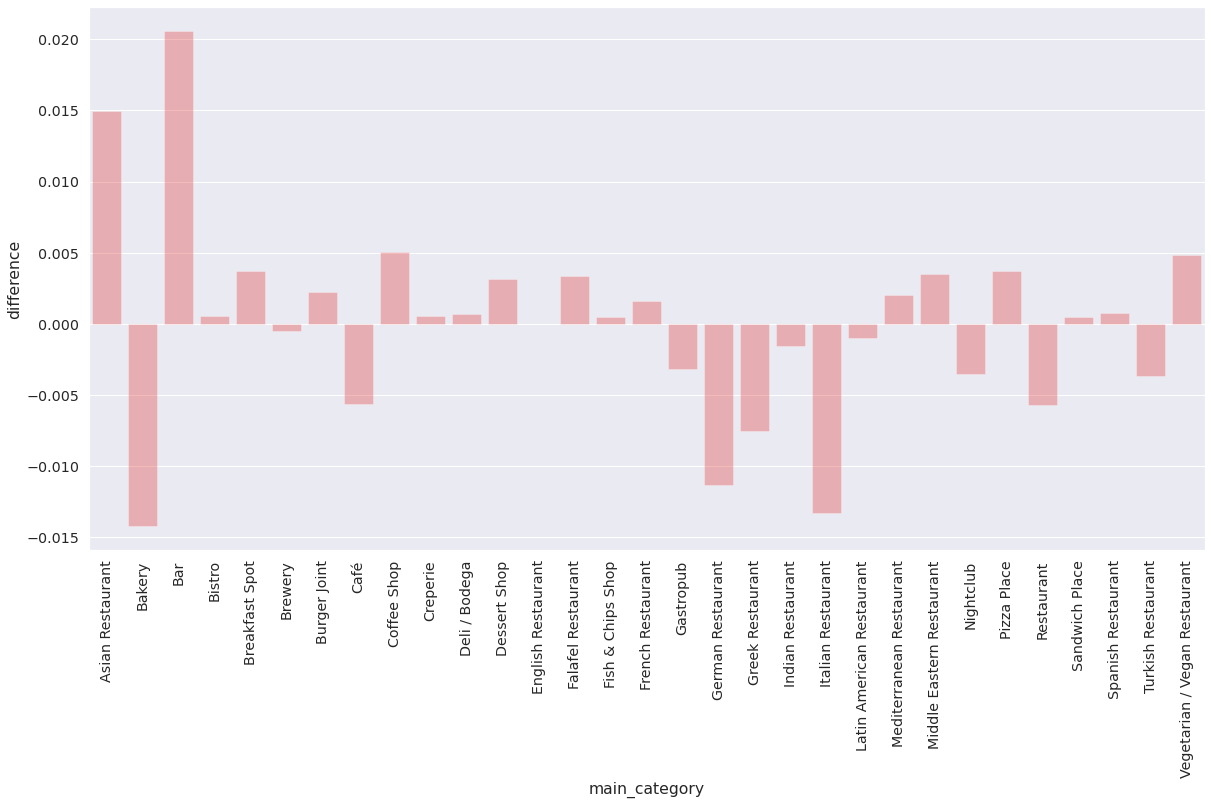

In [15]:
pd.set_option('chained_assignment',None)

df=cat_composition[cat_composition['city']=='Berlin']
df=df[df['main_category'].isin(cat50)]
df2= venues3['Berlin'][venues3['Berlin']['cluster_label']==-1]
tot_unclustered=len(df2)
for cat in categories:
    df.loc[df['main_category']==cat,'n_unclustered']=df2.loc[df2['main_category']==cat].count()[0]

df.loc[:,'n_unclustered_rel']= df['n_unclustered']/tot_unclustered
df['difference']=df['n_venues_rel']-df['n_unclustered_rel']
sns.set(font_scale=1.3,rc={'figure.figsize':(20,10)})
ax=sns.barplot(x='main_category',y='difference',data=df,alpha=0.3,ci=None,color='red')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    

print()

For Asian Restaurants, Bars, Coffee Shops and Vegetarian/Vegan Restaurants the difference between the relative average number and the relative number in the unclustered data is significantly larger than zero. Therefore, these venues are more often located in the clusters we found. On the other hand, the same difference is significantly smaller than zero for Bakeries, Cafés, German Restaurants, Greek Restaurants, Italian Restaurants and venues with the unspecific 'Restaurant' label. These venues are more often outside of clusters. For the bakeries these findings are not surprising, since bakeries can often be found in residential areas, where no venue clusters are to be expected. The inverse could be assumed for Bars, i.e. Bars tend to be outside of residential areas and, therefore, more often clustered. The difference between Asian Restaurants and German, Greek and Italian Restaurants in the distribution is an interesting find of this study. It shows that Asian Restaurants in Berlin tend to be part of spatial culinary clusters while the other named Restaurants tend to be more evenly distributed over the City.

## Pricipal-Component Analysis and Kmeans-Clustering

We try to find patterns in the composition of the spatial clusters found by DBSCAN. In order to do this two methods are used: principal-component analysis (pca) and Kmeans-clustering. The pca shows us which categories are the most interesting for a composition analysis. Before we start we need to apply one-hot-encoding. The venues labeled with "-1" are dropped from the dataset. The venues are grouped by their cluster label with the mean-method, resulting in the relative composition of categories in each cluster.

In [55]:
venues_oh={}
venues_grouped={}
for city in CityList:
    venues_oh[city]=venues3[city][['cluster_label','venue.location.lat','venue.location.lng']].join(pd.get_dummies(venues3[city]['category'], prefix="", prefix_sep=""))
    venues_oh[city]=venues_oh[city][venues_oh[city]['cluster_label']!=-1]
    venues_oh[city].reset_index(drop=True)
    for cat in categories:
        if cat not in venues_oh[city]:
            venues_oh[city][cat]=0.0
    venues_grouped[city] = venues_oh[city].groupby('cluster_label').mean().reset_index()
    venues_grouped[city]
venue_clusters=pd.DataFrame()
for city in [CityList[0]]:
    df=venues_grouped[city]
    df['city']=city
    venue_clusters=venue_clusters.append(df)
#venue_clusters=venue_clusters.fillna(0).reset_index(drop=True)
venue_clusters.reset_index(drop=True)
venue_clusters.head(10)


cluster_label  venue.location.lat  venue.location.lng  African Restaurant  \
0              0           52.527471           13.409240                 0.0   
1              1           52.527191           13.398667                 0.0   
2              2           52.524102           13.409246                 0.0   
3              3           52.527134           13.394119                 0.0   
4              4           52.516794           13.388121                 0.0   
5              5           52.532357           13.396953                 0.0   
6              6           52.533979           13.404100                 0.0   
7              7           52.533575           13.424303                 0.0   
8              8           52.538974           13.408801                 0.0   
9              9           52.536686           13.420335                 0.0   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0             0.000000                     0.0          0.000000   
1             0.000000                     0.0          0.000000   
2             0.000000                     0.0          0.086957   
3             0.000000                     0.0          0.000000   
4             0.000000                     0.0          0.000000   
5             0.000000                     0.0          0.000000   
6             0.000000                     0.0          0.000000   
7             0.050000                     0.0          0.000000   
8             0.037037                     0.0          0.000000   
9             0.000000                     0.0          0.050847   

   Austrian Restaurant  BBQ Joint  Bagel Shop  ...  West-Ukrainian Restaurant  \
0                  0.0   0.000000    0.000000  ...                        0.0   
1                  0.0   0.000000    0.000000  ...                        0.0   
2                  0.0   0.000000    0.000000  ...                        0.0   
3                  0.0   0.000000    0.000000  ...                        0.0   
4                  0.0   0.000000    0.000000  ...                        0.0   
5                  0.0   0.000000    0.000000  ...                        0.0   
6                  0.0   0.000000    0.000000  ...                        0.0   
7                  0.0   0.000000    0.000000  ...                        0.0   
8                  0.0   0.037037    0.000000  ...                        0.0   
9                  0.0   0.000000    0.016949  ...                        0.0   

   Night Market  Other Nightlife  Strip Club  Champagne Bar  Ice Bar  \
0           0.0              0.0         0.0            0.0      0.0   
1           0.0              0.0         0.0            0.0      0.0   
2           0.0              0.0         0.0            0.0      0.0   
3           0.0              0.0         0.0            0.0      0.0   
4           0.0              0.0         0.0            0.0      0.0   
5           0.0              0.0         0.0            0.0      0.0   
6           0.0              0.0         0.0            0.0      0.0   
7           0.0              0.0         0.0            0.0      0.0   
8           0.0              0.0         0.0            0.0      0.0   
9           0.0              0.0         0.0            0.0      0.0   

   Rooftop Bar  Sake Bar  Tiki Bar    city  
0          0.0       0.0       0.0  Berlin  
1          0.0       0.0       0.0  Berlin  
2          0.0       0.0       0.0  Berlin  
3          0.0       0.0       0.0  Berlin  
4          0.0       0.0       0.0  Berlin  
5          0.0       0.0       0.0  Berlin  
6          0.0       0.0       0.0  Berlin  
7          0.0       0.0       0.0  Berlin  
8          0.0       0.0       0.0  Berlin  
9          0.0       0.0       0.0  Berlin  

[10 rows x 373 columns]

"PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on" ([wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis "Principal component analysis")). It can show which features in a dataset are the most important to describe the whole dataset.

Due to one-hot encoding procedure of the 369 culinary categories of the foursquare api we have a 369-dimensional dataset. With the help of pca the features in this dataset with the highest variance can be identified. pca would yield 369 new features, which are perpendicular linear combinations of the original features and are ordered with descending importance. Each of this new features $n_i$ is calculated from the original features $o_j$ with the equation

$n_i = c_{i,1} o_1 + c_{i,2} o_2 + ... c_{i,j} o_j + ...$

where c_{i,j} are the coefficients that transform the old features to the pca-features. 

Let's say we are only interested in the 10 original features that have the highest influence to the most important 30 new features. We pick the first 30 components of our pca and identify the 10 original features that have the highest absolute coefficients $c$ for each of these categories. Furthermore, we drop every category where the contribution to the variance multiplied with the coefficient $c_{i,j}$ is below $0.5%$. We store these categories in the list important_cat. 

In [56]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df=venue_clusters[categories]
n_components=30
pca=PCA(n_components=n_components)
pca.fit(df)

venue_clusters_pca=pca.transform(df)

n_cat=10
tres=0.005

important_cat=[]

for i in range(n_components):
    #print(pca.explained_variance_ratio_[i])
    coeffs=np.argpartition(abs( pca.components_[i] ), -n_cat)[-n_cat:]
    for j in range(n_cat):
        #print(coeffs[j], categories[coeffs[j]], pca.components_[i][coeffs[j]])
        if abs(pca.components_[i][coeffs[j]])*pca.explained_variance_ratio_[i]>tres:
            important_cat.append(categories[coeffs[j]])
#print('explained variance ratio: ' +  str(sum(pca.explained_variance_ratio_)))
important_cat= np.unique(important_cat)
print(len(important_cat))
important_cat

31


array(['Asian Restaurant', 'Bakery', 'Bar', 'Bistro', 'Breakfast Spot',
       'Burger Joint', 'Café', 'Cocktail Bar', 'Coffee Shop',
       'Dessert Shop', 'Doner Restaurant', 'French Restaurant',
       'German Restaurant', 'Hotel Bar', 'Ice Cream Shop',
       'Indian Restaurant', 'Italian Restaurant', 'Korean Restaurant',
       'Middle Eastern Restaurant', 'Nightclub', 'Pizza Place', 'Pub',
       'Restaurant', 'Seafood Restaurant', 'Steakhouse',
       'Sushi Restaurant', 'Trattoria/Osteria', 'Turkish Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant',
       'Wine Bar'], dtype='<U29')

We identified 31 categories which contribute to the largest variance in our dataset. These are the categories we will use to detect patterns in the data of the spatial clusters. We can use the information obtained by pca even further by using the 30 most important new features as the input for the kmeans-clustering. Let's find out what kmeans-clustering would yield depending on the n_clusters parameter. The following code prints the n_clusters parameter and the resulting size of each kmeans-cluster.

In [57]:
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=1, n_init=100).fit(venue_clusters_pca)
    df=venue_clusters
    df['kmeans_cluster_label']=kmeans.labels_
    cc_count=df.groupby('kmeans_cluster_label').count().iloc[:,0].to_list()
    print(i, cc_count)

1 [107]
2 [60, 47]
3 [60, 2, 45]
4 [49, 19, 11, 28]
5 [3, 24, 27, 12, 41]
6 [16, 5, 47, 1, 27, 11]
7 [24, 1, 11, 3, 37, 1, 30]
8 [10, 30, 15, 24, 4, 11, 1, 12]
9 [11, 19, 13, 25, 3, 11, 1, 10, 14]
10 [10, 34, 4, 11, 2, 1, 10, 9, 3, 23]
11 [17, 16, 3, 5, 10, 19, 3, 1, 18, 12, 3]
12 [10, 33, 4, 11, 1, 1, 10, 9, 3, 23, 1, 1]
13 [10, 34, 3, 11, 1, 1, 10, 9, 3, 21, 1, 1, 2]
14 [9, 11, 1, 2, 21, 3, 13, 17, 6, 1, 1, 5, 6, 11]
15 [10, 33, 3, 11, 1, 1, 12, 8, 3, 19, 1, 1, 2, 1, 1]
16 [5, 16, 16, 2, 6, 2, 12, 12, 5, 1, 3, 14, 1, 1, 6, 5]
17 [5, 16, 16, 2, 6, 2, 10, 13, 5, 1, 3, 13, 1, 1, 6, 6, 1]
18 [5, 16, 16, 2, 6, 2, 8, 13, 2, 1, 3, 14, 1, 1, 6, 5, 1, 5]
19 [2, 14, 1, 2, 1, 8, 17, 11, 1, 5, 14, 6, 1, 10, 2, 9, 1, 1, 1]


On the one hand we don't want to have clusters with very high numbers of items (here the items are the spatial clusters) because the significant information will be overlaid with a large amount of noise in these clusters. On the other hand if we choose a to large number for n_clusters a lot of clusters will only have 1 or two items and show now significant trend, i.e. a large n_clusters overfits the data. Note, that it is okay to have some clusters with very few items, since these clusters contain the "exotic" compositions (compositions that are unusual) and will reduce the noise in the other clusters. We compromise on a value of n_clusters of 16 where we have no cluster with more than 20 items and only 6 clusters with less then 5 items.

In [79]:
# set number of clusters
kclusters = 16

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=1, n_init=100).fit(venue_clusters_pca)

# check cluster labels generated for each row in the dataframe
venue_clusters['kmeans_cluster_label']=kmeans.labels_
#venue_clusters[categories]

Let's have a look at the most common venues in each cluster. 

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['cluster_label','kmeans_cluster_label','venue.location.lat','venue.location.lng']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['cluster_label'] = venue_clusters['cluster_label']
venues_sorted['kmeans_cluster_label'] = venue_clusters['kmeans_cluster_label']
venues_sorted['venue.location.lat'] = venue_clusters['venue.location.lat']
venues_sorted['venue.location.lng'] = venue_clusters['venue.location.lng']
venues_sorted=venues_sorted.sort_values('kmeans_cluster_label')

for ind in range(len(venue_clusters)):
    venues_sorted.iloc[ind, 4:] = return_most_common_venues(venue_clusters.drop(['kmeans_cluster_label','cluster_label','venue.location.lat','venue.location.lng','city'], 1).iloc[ind, :], num_top_venues)
#venues_sorted.head(20)

#frequent_categories=venues_sorted[['1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']].stack().unique().tolist()
#frequent_categories=frequent_categories

cc_count=venues_sorted.groupby('kmeans_cluster_label').count().iloc[:,0].to_list()
cc_count_city={}

for city in CityList:
    cc_count_city[city]=venue_clusters[venue_clusters['city']==city].groupby('kmeans_cluster_label').count().iloc[:,0].reindex(list(range(0,kclusters)),fill_value=0).tolist()


venues_avg=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city','kmeans_cluster_label'],axis=1).mean()
venues_avg

#cc_count#_city['Berlin']
venues_sorted

cluster_label  kmeans_cluster_label  venue.location.lat  \
21              21                     0           52.498239   
67              67                     0           52.511753   
72              72                     0           52.530193   
63              63                     0           52.519466   
101            101                     0           52.486812   
..             ...                   ...                 ...   
59              59                    15           52.483277   
57              57                    15           52.473850   
100            100                    15           52.495379   
103            103                    15           52.555460   
19              19                    15           52.476912   

     venue.location.lng  1st Most Common Venue 2nd Most Common Venue  \
21            13.318542     Italian Restaurant   Japanese Restaurant   
67            13.417134            Coffee Shop        Breakfast Spot   
72            13.383884  Vietnamese Restaurant            Restaurant   
63            13.299278             Restaurant    Italian Restaurant   
101           13.322698                   Café    Italian Restaurant   
..                  ...                    ...                   ...   
59            13.440996     Italian Restaurant      Greek Restaurant   
57            13.448823                   Café           Pizza Place   
100           13.429892              Nightclub             Hotel Bar   
103           13.342709              Nightclub                   Bar   
19            13.422741                   Café          Burger Joint   

             3rd Most Common Venue       4th Most Common Venue  \
21           Vietnamese Restaurant                    Beer Bar   
67      Modern European Restaurant                      Bistro   
72                Asian Restaurant                 Coffee Shop   
63                     Coffee Shop  Modern European Restaurant   
101                      Hotel Bar                Cocktail Bar   
..                             ...                         ...   
59               Trattoria/Osteria                Dessert Shop   
57               Indian Restaurant                         Bar   
100                     Restaurant                  Steakhouse   
103  Vegetarian / Vegan Restaurant       Vietnamese Restaurant   
19                Doner Restaurant                Cocktail Bar   

             5th Most Common Venue  
21               Fondue Restaurant  
67                Ramen Restaurant  
72              Falafel Restaurant  
63   Vegetarian / Vegan Restaurant  
101                    Coffee Shop  
..                             ...  
59               German Restaurant  
57                   Deli / Bodega  
100                       Tiki Bar  
103                       Tiki Bar  
19                             Bar  

[107 rows x 9 columns]

In [76]:
venues_sorted[venues_sorted['kmeans_cluster_label']==4]

cluster_label  kmeans_cluster_label  venue.location.lat  \
105            105                     4           52.482609   

     venue.location.lng 1st Most Common Venue 2nd Most Common Venue  \
105           13.430244                  Café                   Bar   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
105        Breakfast Spot        Ice Cream Shop                Bakery

In [81]:
i=0
for count in cc_count:
    if count > 3:
        i=i+1
cc_large_index=np.argpartition( cc_count, -i)[-i:]
cc_large_index


cc_large=[]
for i in cc_large_index:
    cc_large.append(i)
    
cc_large




[15, 0, 8, 1, 6, 11, 4, 2, 14, 7]

/home/tobias/miniconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x360 with 0 Axes>

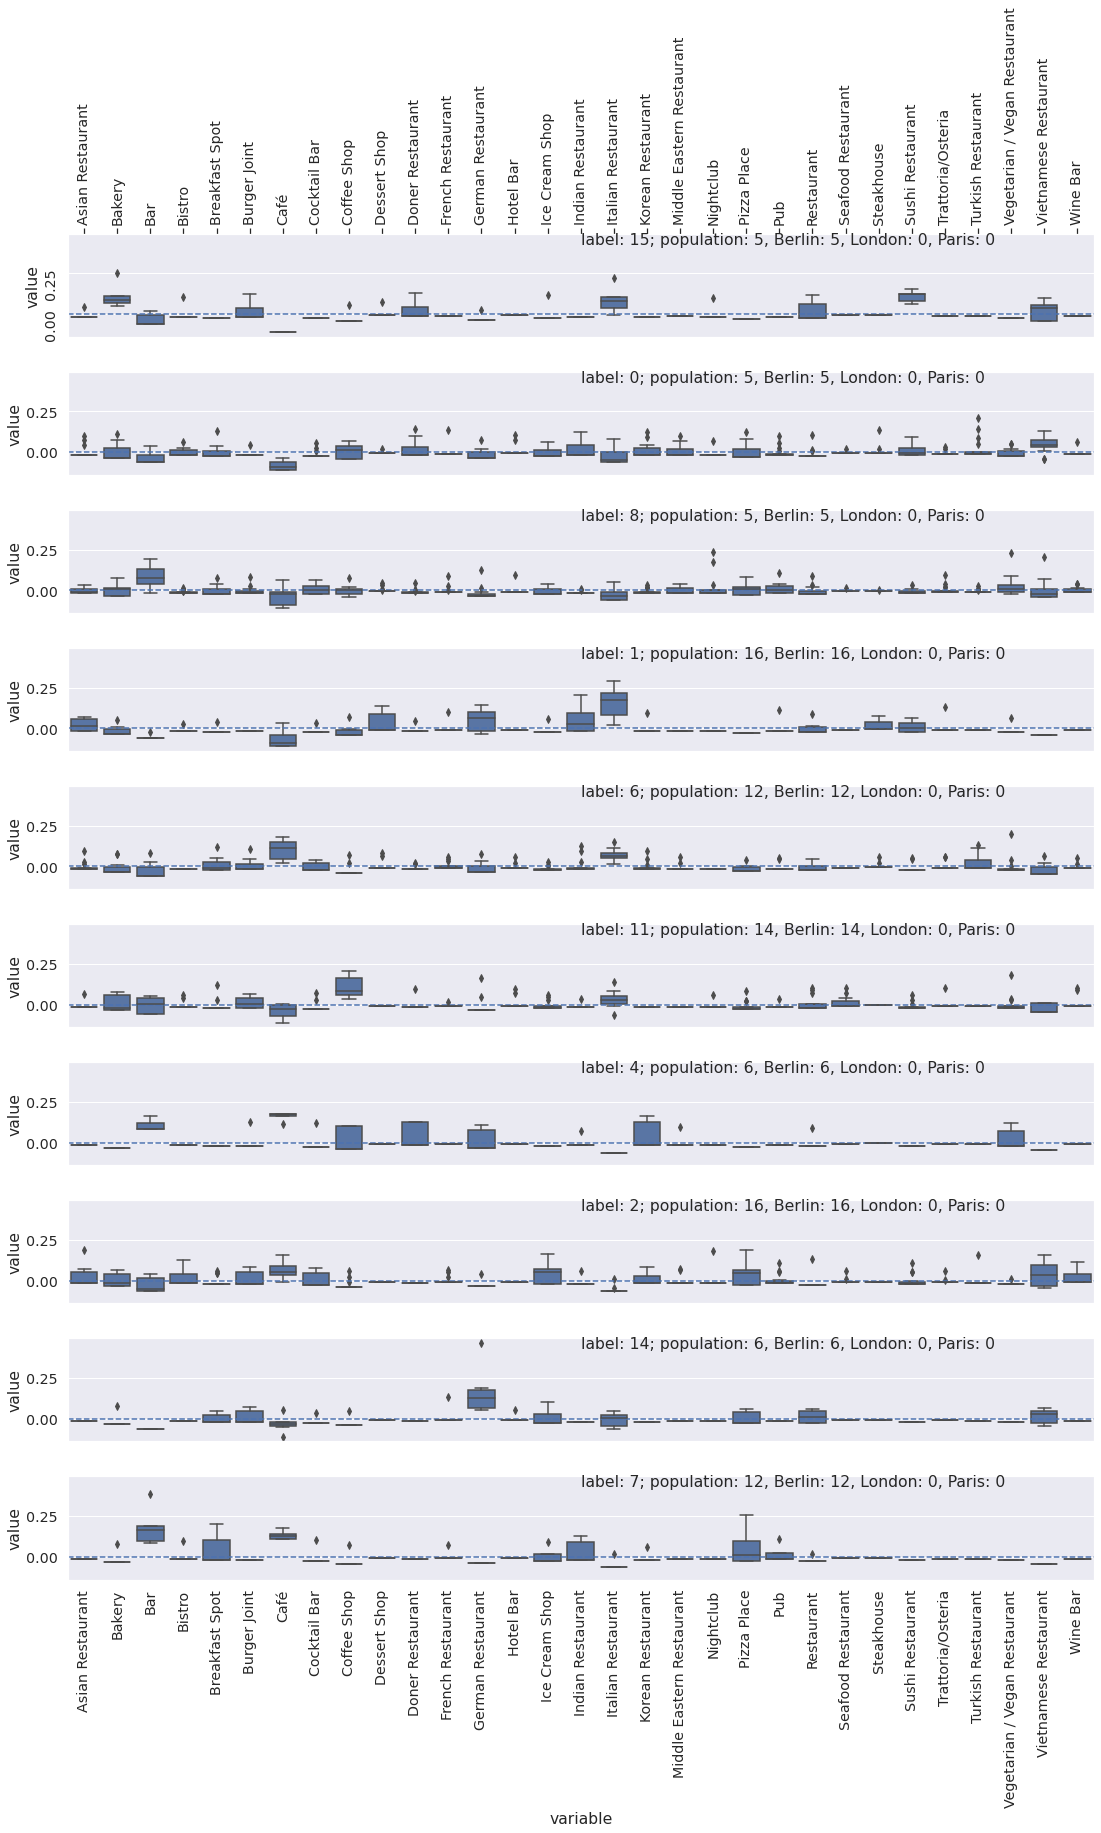

In [83]:
plt.figure(figsize=(20,5))
df=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city'],axis=1)
for col in df.drop(['kmeans_cluster_label'],axis=1).columns:
    df[col]=df[col]-venues_avg[col]
df=df.melt(id_vars='kmeans_cluster_label')
df=df[df['variable'].isin(important_cat)]
df=df[df['kmeans_cluster_label'].isin(cc_large)]

n_labels=len(df['kmeans_cluster_label'].unique())

grid= sns.FacetGrid(df, row='kmeans_cluster_label', height=2, aspect=8,despine=False)
#for i in df['kmeans_cluster_label'].unique():
#    df2=df[df['kmeans_cluster_label']==i]
grid.map(sns.boxplot,'variable','value')
grid.set_xticklabels(rotation=90)
grid.set_titles()
#grid.xaxis.tick_top()

for i,l in zip(range(nlabels),cc_large):
    grid.axes[i][0].axhline(0, ls='--')
    grid.axes[i][0].set_title("")
    text = "label: " + str(l) + "; population: " + str(cc_count[l])
    for city in CityList:
        text =text + ", " + city + ": " + str(cc_count_city[city][l])
    grid.axes[i][0].text(0.5,0.9, text, transform=grid.axes[i][0].transAxes)
    if i==0:
        grid.axes[i][0].xaxis.set_ticks_position("top")
        grid.axes[i][0].tick_params(labelrotation=90)

In [82]:
n=0
colors_array = cm.hsv(np.linspace(0, 1, n_labels))
palette = [colors.rgb2hex(i) for i in colors_array]



map3 = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)
for i,l in zip(range(nlabels),cc_large):
    df=venues_sorted[venues_sorted['kmeans_cluster_label']==l]
    for lat, lng in zip(df['venue.location.lat'], df['venue.location.lng']):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=str(l),
            color=palette[i],
            fill=True,
            fill_color=palette[i],
            fill_opacity=1,
            parse_html=False).add_to(map3)

map3

IndexError: list index out of range

In [257]:

df=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city'],axis=1).transpose()
df=df[df.index.isin(frequent_categories)].transpose()
df
sns.pairplot(df)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f00eaad9200> (for post_execute):


KeyboardInterrupt: 

variable     value
index                                           
Asian Restaurant                     0  0.012296
Austrian Restaurant                  0  0.015909
Bagel Shop                           0  0.002934
Bakery                               0  0.038679
Bar                                  0  0.145430
...                                ...       ...
Trattoria/Osteria                    5  0.000000
Turkish Restaurant                   5  0.015883
Vegetarian / Vegan Restaurant        5  0.007555
Vietnamese Restaurant                5  0.051699
Wine Bar                             5  0.000000

[312 rows x 2 columns]

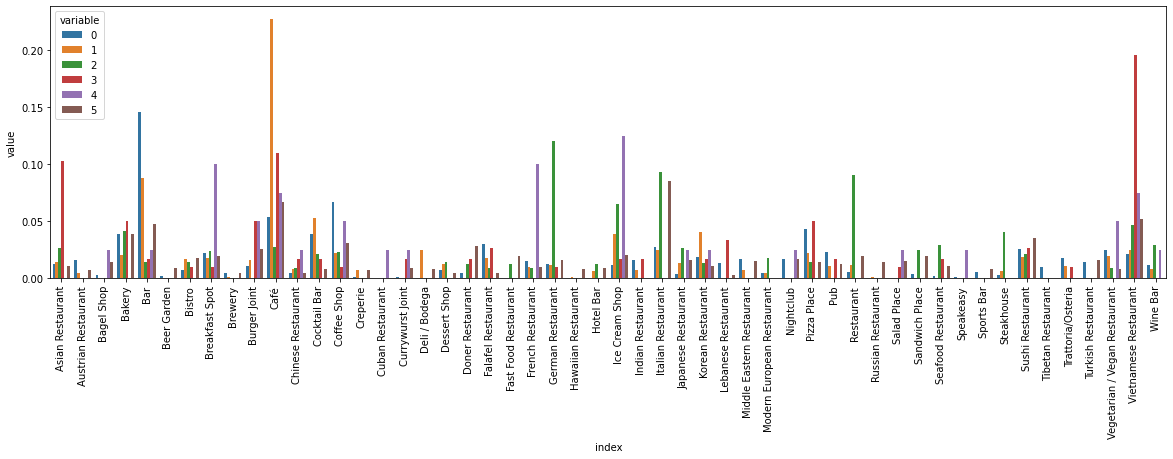

In [37]:
df=venue_clusters.groupby('kmeans_cluster_label').mean().reset_index().drop(['kmeans_cluster_label','cluster_label','venue.location.lat','venue.location.lng'],axis=1).transpose()
#df2=df.stack()
df=df[df.index.isin(frequent_categories)]
df2=pd.melt(df.reset_index(),id_vars='index')
df2=df2.set_index('index')
plt.figure(figsize=(20,5))
ax=sns.barplot(x=df2.index,y=df2['value'],hue=df2['variable'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#print()
df2

In [ ]:
sns.bars()